# **Dependencies**

In [1]:
# from huggingface_hub import login
# login(token="hf_peeXvbkzEPXLEhbuygburSUrJdoMQvUmldPygfygvfeb")

In [10]:
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
)
from peft import get_peft_model, LoraConfig, prepare_model_for_kbit_training, TaskType
from datasets import load_dataset, Dataset
import torch
from accelerate import Accelerator
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
# device = "cuda:2" if torch.cuda.is_available() else "cpu"
# torch.cuda.set_device(device)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
DEVICE_MAP = "auto"  # {'': torch.cuda.current_device()}

# **Data Processing**

In [3]:
model_id = "google/t5-v1_1-xxl"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map=DEVICE_MAP,
    cache_dir="/app/model",
)
tokenizer = AutoTokenizer.from_pretrained(
    model_id, cache_dir="/app/model", add_eos_token=True, add_bos_token=True
)
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [44]:
# Load the provided Excel file
file_path = "/app/data/raw_data.xlsx"
data = pd.read_excel(file_path)


def format_data(row):
    input_text = row["Наименование заказчика"]
    output_text = f"Простая/составная: {row['Простая/составная']}; Продукт/рукав: {row['Продукт/рукав']}; Длина: {row['Длина']}; Фитинг левый: {row['Фитинг левый']}; Фитинг правый: {row['Фитинг правый']}"
    return {
        "input": input_text,  # Lowercase keys are often preferred in datasets
        "output": output_text,
    }


# Filter and clean the data
data = data[
    [
        "Наименование заказчика",
        "Простая/составная",
        "Продукт/рукав",
        "Длина",
        "Фитинг левый",
        "Фитинг правый",
    ]
]
data.dropna(inplace=True)

# Apply formatting and create a Pandas DataFrame
formatted_data_df = pd.DataFrame(data.apply(format_data, axis=1).tolist())
formatted_data_df.to_csv("/app/data/formatted_data.csv", index=False)
# Convert the Pandas DataFrame to a Hugging Face dataset
dataset = Dataset.from_pandas(formatted_data_df)

In [5]:
# Splitting the dataset into training and test sets
test_size = 30  # Number of test samples
train_dataset, test_dataset = dataset.train_test_split(
    test_size=test_size, seed=123
).values()

In [6]:
prefix = "Please translate customer requests to positions in the catalog: "
suffix = " Answer: "


def preprocess_function(examples):
    inputs = [prefix + doc + suffix for doc in examples["input"]]
    model_inputs = tokenizer(inputs)
    labels = tokenizer(examples["output"])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [7]:
# Apply preprocessing
train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2835 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

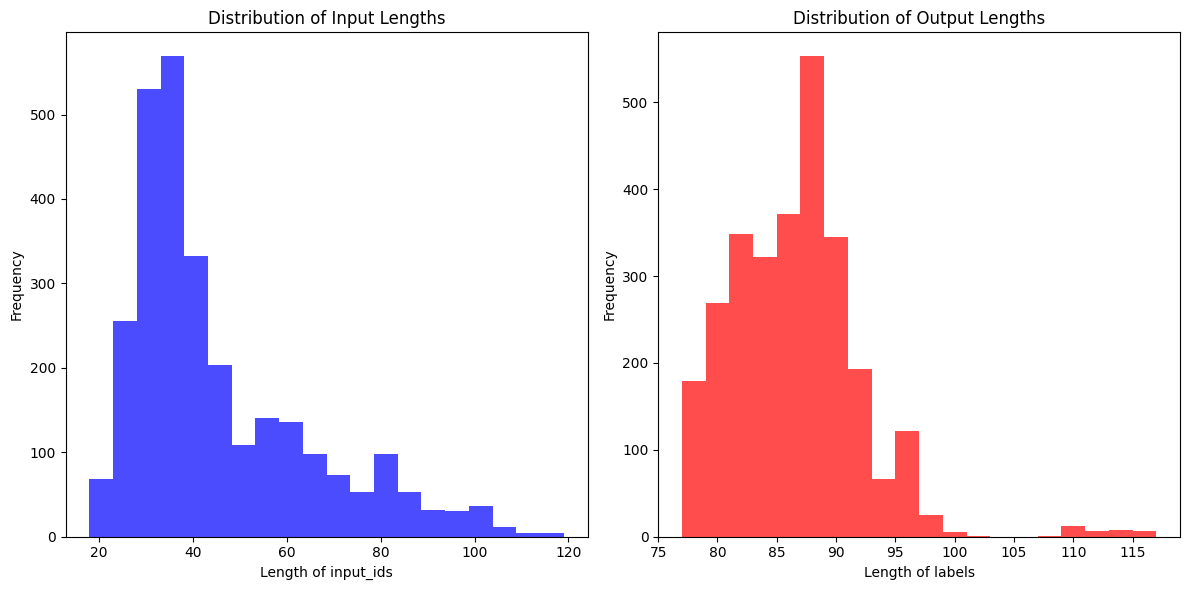

In [11]:
def plot_data_lengths(tokenized_train_dataset):
    input_lengths = [len(x["input_ids"]) for x in tokenized_train_dataset]
    output_lengths = [len(x["labels"]) for x in tokenized_train_dataset]

    # Creating the figure and subplots
    plt.figure(figsize=(12, 6))

    # Subplot for input lengths
    plt.subplot(1, 2, 1)
    plt.hist(input_lengths, bins=20, alpha=0.7, color="blue")
    plt.xlabel("Length of input_ids")
    plt.ylabel("Frequency")
    plt.title("Distribution of Input Lengths")

    # Subplot for output lengths
    plt.subplot(1, 2, 2)
    plt.hist(output_lengths, bins=20, alpha=0.7, color="red")
    plt.xlabel("Length of labels")
    plt.ylabel("Frequency")
    plt.title("Distribution of Output Lengths")

    plt.tight_layout()
    plt.show()


# Example usage
plot_data_lengths(train_dataset)

In [12]:
def preprocess_function2(examples):
    inputs = [prefix + doc + suffix for doc in examples["input"]]
    model_inputs = tokenizer(inputs, max_length=128, padding="max_length")
    labels = tokenizer(examples["output"], max_length=128, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [13]:
tokenized_train_dataset = train_dataset.map(preprocess_function2, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function2, batched=True)

Map:   0%|          | 0/2835 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

In [23]:
# Initialize Accelerator
accelerator = Accelerator()
model, tokenizer, data_collator = accelerator.prepare(model, tokenizer, data_collator)

### How does the base model do?

In [31]:
eval_prompt = tokenized_test_dataset["input"][12]
print(eval_prompt)

Рукав РВД 20-215-11000 NPTF 3/4" 0/0


In [32]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    model_id, add_bos_token=True, cache_dir="app/model"
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(
        eval_tokenizer.decode(
            model.generate(**model_input, max_new_tokens=256)[0],
            skip_special_tokens=True,
        )
    )

ув  20-215-11000 NPTF 3/4" 0/0                                


# **Training**

In [34]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [35]:
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 4096)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 4096)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear4bit(in_features=4096, out_features=4096, bias=False)
              (k): Linear4bit(in_features=4096, out_features=4096, bias=False)
              (v): Linear4bit(in_features=4096, out_features=4096, bias=False)
              (o): Linear4bit(in_features=4096, out_features=4096, bias=False)
              (relative_attention_bias): Embedding(32, 64)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear4bit(in_features=4096, out_features=10240, bias=False)
              (wi_1): Linear4bit(in_features=4096, out_features=

In [36]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.01,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
    target_modules="all-linear",
)
model = get_peft_model(model, lora_config)

In [38]:
model.print_trainable_parameters()

trainable params: 70,778,880 || all params: 11,206,111,232 || trainable%: 0.6316


In [39]:
project = "rukava"
base_model_name = "t5-1.1-xll"
run_name = base_model_name + "-" + project
output_dir = "/app/model/lora/" + run_name

training_arg = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    warmup_steps=2,
    overwrite_output_dir=True,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    max_steps=1000,
    learning_rate=2e-5,
    bf16=True,
    optim="paged_adamw_8bit",
    save_strategy="steps",
    save_steps=1000,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=200,
    evaluation_strategy="steps", # Evaluate the model every logging step
    eval_steps=200,               # Evaluate and save checkpoints every 50 steps
    do_eval=True,                # Perform evaluation at the end of training
    # num_train_epochs=5,
    push_to_hub=False,
    report_to=[],
)
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    data_collator=data_collator,
    args=training_arg,
)
trainer.train()

/opt/conda/envs/peft/lib/python3.8/site-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
/opt/conda/envs/peft/lib/python3.8/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,No log,4.483695
50,No log,3.564068
75,No log,2.834791
100,5.435600,2.624498
125,5.435600,2.140609
150,5.435600,1.750748
175,5.435600,1.419728
200,2.315100,1.087520
225,2.315100,0.840088
250,2.315100,0.685295


TrainOutput(global_step=500, training_loss=1.9986945419311524, metrics={'train_runtime': 1581.0503, 'train_samples_per_second': 5.06, 'train_steps_per_second': 0.316, 'total_flos': 6.782065881749914e+16, 'train_loss': 1.9986945419311524, 'epoch': 2.808988764044944})

# **Loading the Model**

In [56]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
import random

base_model_id = "google/t5-v1_1-xxl"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map=DEVICE_MAP,
    trust_remote_code=True,
    cache_dir="/app/model",
)
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id, cache_dir="/app/model", add_eos_token=True, add_bos_token=True
)

ft_model = PeftModel.from_pretrained(base_model, "/app/model/lora/t5-1.1-xll-rukava/checkpoint-500")

# **Inference**

In [52]:
# Read formatted data
formated_data_df = pd.read_csv("/app/data/formatted_data.csv", index_col=False)


In [64]:
# inference on GPU
prefix = "Please translate customer requests to positions in the catalog: "
suffix = " Answer: "

index = random.randint(0, formated_data_df.shape[0])
input_text, expected_output = formatted_data_df.iloc[index]
prompt = prefix + input_text + suffix

# Encode the prompt
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
# Deterministic generation settings
generation_config = {
    "max_length": 129,                 # Reasonable maximum length for output sequences
    "num_beams": 3,                   # Fewer beams for less diversity but more confidence
    "no_repeat_ngram_size": 2,        # Avoid repeating n-grams to maintain quality
    "temperature": 0.3,               # Lower temperature for more deterministic outputs
    "top_k": 5,                       # Top-k sampling low
    "top_p": 0.99,                    # Disables nucleus sampling, making predictions more deterministic
    "repetition_penalty": 1.1,        # Higher penalty to discourage repetition
    "length_penalty": 1.0,            # Default length penalty to not favor longer or shorter sequences
    "early_stopping": True,           # Stop when num_beams sentences are finished
    "pad_token_id": tokenizer.pad_token_id,  # Padding token if required by the model
    "eos_token_id": tokenizer.eos_token_id,  # End-of-sequence token id
}

with torch.no_grad():
    predicted_output_ids = model.generate(**model_input, **generation_config)
    predicted_output = tokenizer.decode(predicted_output_ids[0], skip_special_tokens=True)

# Print results
print("Input:", input_text)
print("Expected Output:", expected_output)
print("Predicted Output:", predicted_output)

Input: Рукав РВД 12-100-900-0,18-36.90°/36-М24х1,5/М24х1,5-ХЛ1 41.77385 ИТТ
Expected Output: Простая/составная: Составная; Продукт/рукав: 2SN DN12(-55); Длина: 900; Фитинг левый: DKOS24x1,5(90)DN12; Фитинг правый: DKOS24x1,5DN12
Predicted Output: роста/составна: NPTF 3/4" 0/0 DN20;  нет наруно длин, толив: 3/4", лина: 3"
